# 1. Import Dependencies

In [97]:
from datasets import load_dataset # Hugging Face library for accessing and streaming large public text datasets
from transformers import AutoTokenizer # Provides transformer-compatible tokenizers
from torch.utils.data import Dataset, DataLoader # PyTorch utilities for building custom datasets and data loaders
from torch.nn.utils.rnn import pad_sequence # Function to pad variable-length sequences in a batch to the same length
from tqdm import tqdm # Progress-bar library for displaying iteration progress in loops
import torch, regex as re, unicodedata # PyTorch core library
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
# regex: advanced regular-expression library used for text cleaning and normalization
# unicodedata: handles Unicode normalization to ensure consistent text representation

# 2. Dataset processing pipeline

## Collect Data from hugging face

In [ ]:
wiki = load_dataset("wikimedia/wikipedia", "20231101.en", split="train", streaming=True)
# Load the English Wikipedia dataset (March 2022 dump) from the Hugging Face Hub.
owt = load_dataset("HuggingFaceFW/fineweb-edu", split="train", streaming=True)
# Load the OpenWebText dataset — a large collection of web pages
texts = []
# Create an empty list to hold text samples collected from both datasets.

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2410 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2410 [00:00<?, ?it/s]

## Collect sample from each dataset

In [99]:
for i,t in enumerate(wiki):
    texts.append(t["text"])
    if i >= 255:
        break
for i,t in enumerate(owt):
    texts.append(t["text"])
    if i >= 255:
        break
print(f"get {len(texts)} documents")

get 512 documents


## Cleaning and Normalization

In [100]:
#Normalize and clean a raw text string.
def clean_text(t: str) -> str:
    """Normalize text: lowercase, remove HTML, extra whitespace, long repeats."""
    t = unicodedata.normalize("NFKC", t)    # normalize unicode form
    t = t.lower()                           # convert to lowercase
    t = re.sub(r"<[^>]+>", " ", t)          # remove HTML tags
    t = re.sub(r"\s+", " ", t).strip()      # collapse spaces
    t = re.sub(r"(.)\1{4,}", r"\1\1\1", t)  # compress long repeats
    return t

#Initialize an empty list for cleaned documents, and a set to keep track of seen texts
cleaned, seen = [], set()

for txt in texts:
    # Skip empty or very short documents (< 50 words)
    if not txt or len(txt.split()) < 50:
        continue
    txt = clean_text(txt)
    if txt in seen:
        continue
    seen.add(txt)
    cleaned.append(txt)
print(f"After cleaning: {len(cleaned)} unique documents")

After cleaning: 511 unique documents


## Tokenization and chunking

In [101]:
# Load a pretrained GPT-2 tokenizer from the Hugging Face Transformers library.
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Padding tokens are needed when batching sequences of different lengths.
# Here we assign the padding token to be the same as the EOS
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Define the maximum sequence length
block_size = 128
# Initialize an empty list to store tokenized blocks (lists of token IDs).
tokenized_blocks = []

# Iterate through each cleaned document and tokenize it.
# tqdm provides a progress bar for monitoring the tokenization process.
for t in tqdm(cleaned, desc="Tokenizing"):
    # Convert text to a list of integer token IDs.
    ids = tokenizer.encode(t, add_special_tokens=False)

    # Append the EOS token ID at the end of each document, to indicate the end of a sequence.
    ids.append(tokenizer.eos_token_id)

    # If a document is longer than block_size, we split it into consecutive chunks of equal length
    # This ensures each training sample fits within the model's maximum context window.
    for i in range(0, len(ids), block_size):
        tokenized_blocks.append(ids[i:i+block_size])

print(f"Created {len(tokenized_blocks)} tokenized chunks")

Tokenizing: 100%|██████████| 511/511 [00:05<00:00, 91.68it/s] 

Created 15305 tokenized chunks


## Split to train/test

In [102]:
# Split into train/val
split = int(0.9 * len(tokenized_blocks))
train_ids = tokenized_blocks[:split]
val_ids = tokenized_blocks[split:]

# Save them
np.save("train.npy", np.array(train_ids, dtype=object), allow_pickle=True)
np.save("val.npy",   np.array(val_ids,   dtype=object), allow_pickle=True)

# 3. Model Implementation

## Build mini-GPT

In [103]:
class MiniGPT(nn.Module):
    def __init__(self, vocab_size, block_size=128, d_model=128, n_heads=4, n_layers=2):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(block_size, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model,
                n_heads,
                4 * d_model,
                activation='gelu',
                batch_first=True
            )
            for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size)
        self.block_size = block_size

    def forward(self, x):
      B, T = x.shape
      pos = torch.arange(T, device=x.device)
      x = self.tok_emb(x) + self.pos_emb(pos)

      mask = torch.tril(torch.ones(T, T, device=x.device))
      mask = mask.masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, 0.0)

      for layer in self.layers:
          x = layer(x, src_mask=mask)

      x = self.ln(x)
      logits = self.head(x)
      return logits



## Load Data for Training

In [104]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Custom dataset class
class TokenDataset(Dataset):
    def __init__(self, blocks):
        # Convert each token list to a torch tensor
        self.blocks = [torch.tensor(b, dtype=torch.long) for b in blocks]

    def __len__(self):
        return len(self.blocks)

    def __getitem__(self, i):
        x = self.blocks[i][:-1]  # input tokens
        y = self.blocks[i][1:]   # next-token targets
        return x, y


# Custom collate function for padding
def collate_batch(batch):
    xs, ys = zip(*batch)
    pad_id = tokenizer.pad_token_id  # pad with eos_token if needed
    xs = pad_sequence(xs, batch_first=True, padding_value=pad_id)
    ys = pad_sequence(ys, batch_first=True, padding_value=pad_id)
    return xs, ys


# Load saved tokenized data
train_ids = np.load("train.npy", allow_pickle=True)
val_ids   = np.load("val.npy", allow_pickle=True)

# Use collate_fn here!
train_loader = DataLoader(
    TokenDataset(train_ids),
    batch_size=32,
    shuffle=True,
    collate_fn=collate_batch
)

val_loader = DataLoader(
    TokenDataset(val_ids),
    batch_size=64,
    collate_fn=collate_batch
)


In [105]:
import torch
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CUDA available: True
GPU: Tesla T4


## Model training

In [106]:
import torch.nn.functional as F
import math
from tqdm import tqdm  # progress bar library
import os

os.makedirs("checkpoints", exist_ok=True)


device = "cuda" if torch.cuda.is_available() else "cpu"
pad_token_id = tokenizer.pad_token_id

model = MiniGPT(vocab_size=tokenizer.vocab_size).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# Evaluation loop with progress bar
def evaluate(loader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Evaluating", leave=False):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                y.view(-1),
                ignore_index=pad_token_id
            )
            losses.append(loss.item())
    return sum(losses) / len(losses)


# Training loop with progress bar
train_losses, val_losses = [], []
epochs = 5

for epoch in range(epochs):
    model.train()
    total = 0

    # tqdm progress bar for each epoch
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for x, y in progress_bar:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            y.view(-1),
            ignore_index=pad_token_id
        )
        loss.backward()

        optimizer.step()
        total += loss.item()

        # show running loss in progress bar
        progress_bar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    # evaluate after each epoch
    avg_train = total / len(train_loader)
    avg_val = evaluate(val_loader)
    ppl = math.exp(avg_val)

    print(f"\nEpoch {epoch+1}: Train={avg_train:.4f}, Val={avg_val:.4f}, PPL={ppl:.2f}")
    torch.save(model.state_dict(), f"checkpoints/mini_gpt_epoch{epoch+1}.pt")

    train_losses.append(avg_train)
    val_losses.append(avg_val)


Epoch 1/5: 100%|██████████| 431/431 [00:40<00:00, 10.58it/s, batch_loss=6.8819]



Epoch 1: Train=7.4779, Val=7.2010, PPL=1340.81


Epoch 2/5: 100%|██████████| 431/431 [00:38<00:00, 11.18it/s, batch_loss=6.8068]



Epoch 2: Train=6.6148, Val=6.8783, PPL=971.00


Epoch 3/5: 100%|██████████| 431/431 [00:40<00:00, 10.73it/s, batch_loss=6.1704]



Epoch 3: Train=6.2197, Val=6.7306, PPL=837.68


Epoch 4/5: 100%|██████████| 431/431 [00:38<00:00, 11.05it/s, batch_loss=6.0755]



Epoch 4: Train=5.9571, Val=6.6482, PPL=771.43


Epoch 5/5: 100%|██████████| 431/431 [00:39<00:00, 10.85it/s, batch_loss=5.7464]



Epoch 5: Train=5.7577, Val=6.5886, PPL=726.77


# Result

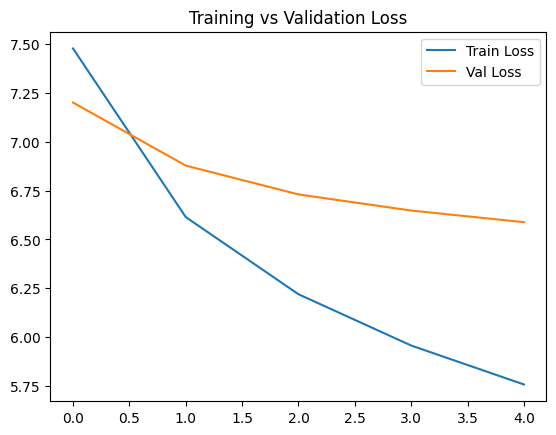

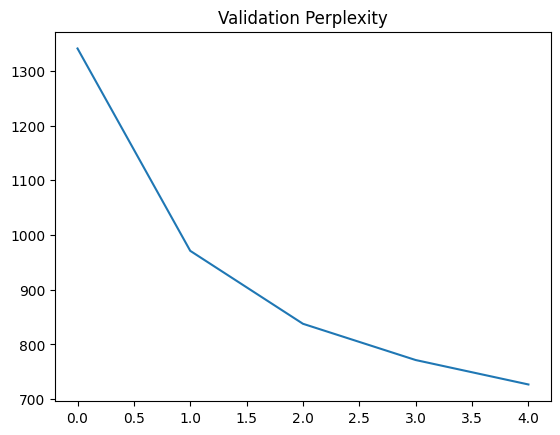

In [107]:
import matplotlib.pyplot as plt, numpy as np
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Training vs Validation Loss'); plt.show()

plt.plot(np.exp(val_losses)); plt.title('Validation Perplexity'); plt.show()

In [108]:
#!ls -lh checkpoints/

In [109]:
#!zip -r mini_gpt_checkpoints.zip checkpoints/
#from google.colab import files
#files.download("mini_gpt_checkpoints.zip")
